<a href="https://colab.research.google.com/github/Shikhas/Portfolio-Management-using-RL/blob/master/Asset_allocation_final_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
from itertools import combinations, permutations
from matplotlib import pyplot as plt
import random

In [0]:
# Initializations
T = 100 # total time period
P = 4 # Number of assets in portfolio
A = [0.1, 0.2, 0.3, 0.4] # Set of possible fractions allowed to invest in. Note: Keep the set such that no P-1 elements add up to 1.
C = 0.01 # Transaction cost, let's keep this constant or 0 for now
B = 1000 # Total balance available to invest

In [0]:
ACTIONS = list(permutations(A, P-1))
ACTIONS = list(map(lambda r: list(r), ACTIONS)) # converting to a list of lists as tuples ain't mutable.

for item in ACTIONS:
  item.insert(0, round(1-sum(item), 1))

#START = ACTIONS[np.random.choice(len(ACTIONS))] # A random start state to the RL problem, defining it here to keep common across episodes


In [0]:
START = [0.1,0.2,0.3,0.4]

In [0]:
# Probability for exploration - epsilon
EPSILON = 0.3
# Step size
ALPHA = 0.01
# Gamma - discount factor - for Q-Learning, Sarsa and Expected Sarsa
GAMMA = 0.9

In [0]:
# Portfolio definition
expected_asset_return = np.linspace(10, 50, P)
asset_risk = np.linspace(0, 10, P)

In [0]:
portfolio = []
for mu, sigma in zip(expected_asset_return, asset_risk):
  portfolio.append(
      np.random.normal(mu, sigma, T)
  )

In [0]:
def compute_variance_covariance_matrix(portfolio_data):
  X = np.array(portfolio_data)
  m = np.mean(X, axis=1)
  z = np.zeros((P, P))
  np.fill_diagonal(z, m)
  X_mean = z @ np.ones((P, T)) # This produces a P * T matrix with respective mean filled along the rows
  X_diff = X - X_mean # Payoff deviation from mean
  var_cov = (X_diff @ X_diff.T)/T # This is our variance-covariance matrix
  return var_cov

In [0]:
asset_types = ["Government Bond", "Cash Equivalents", "Real Estate derivatives", "Equities"]  # These types don't reflect truly the risk and expected
# payoff taken into consideration for simulation

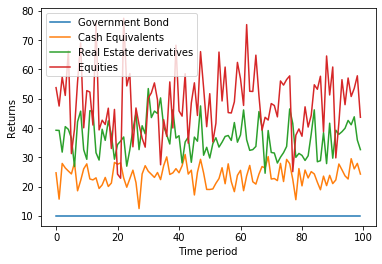

In [0]:
axs = plt.gca()
for p, asset_type in zip(portfolio, asset_types):
  axs.plot(range(T), p, label=asset_type)

axs.set_xlabel("Time period")
axs.set_ylabel("Returns")
axs.legend()
plt.show()

In [0]:
var_cov = compute_variance_covariance_matrix(portfolio)

In [0]:
var_cov

array([[  0.        ,   0.        ,   0.        ,   0.        ],
       [  0.        ,  11.88138632,   1.1502778 ,  -0.17409854],
       [  0.        ,   1.1502778 ,  35.30147272,  -1.4368124 ],
       [  0.        ,  -0.17409854,  -1.4368124 , 121.40513558]])

In [0]:
# Verifying the Variance Covariance matrix, that it indeed is close to the values used for simulation
asset_risk**2  # checking variance

array([  0.        ,  11.11111111,  44.44444444, 100.        ])

In [0]:
def reward_function(state, action, cov_matrix, expected_pay_vec):
  """
  Reward function definition
  State: Current proportion of allocation
  Weight: Action we are taking
  payoff_vector: Expected payoff/returns of respective assets
  """
  weight = np.array(action)
  weight.resize(P, 1) # column vector
  payoff_vector = expected_pay_vec.copy()
  payoff_vector.resize(P,1)
  lambda_attr = np.random.rand() # continuous uniform distribution
  
  risk_free_weight = weight[0]
  risk_free_payoff = payoff_vector[0]
  risky_wt = weight[1:]
  risky_payoff = payoff_vector[1:]
  risky_wt_transpose = risky_wt.T
  risky_cov = cov_matrix[1:,1:]

  risk_free_reward = risk_free_weight*risk_free_payoff
  reward = risk_free_reward + (
      risky_wt_transpose @ risky_payoff) - 0.5*(risky_wt_transpose @risky_cov) @ risky_wt
  
  delta_states = np.array(state).reshape(P,1) - weight
  transaction_cost = C *B* np.sqrt(sum(delta_states ** 2)) # Transaction cost
  return (reward - transaction_cost).flatten()[0] # Payoff earned - transaction cost

In [0]:
reward_function([0.1, 0.2, 0.3, 0.4], [0.2, 0.3, 0.4, 0.1], var_cov, expected_asset_return)

21.161421288083766

In [0]:
# Choose an action based on epsilon greedy algorithm
def choose_action(current_state, current_time, q_value, eps):
    index_current_state = ACTIONS.index(current_state)
    if np.random.choice([0, 1], 1, p=[1-eps, eps]) == 1:  # Exploration with epsilon probability
        action = np.random.choice(len(ACTIONS))
    else:  # Exploit based on the attractiveness of the current state
        values_ = q_value[index_current_state, current_time, :]
        action = np.random.choice([action_ for action_, value_ in enumerate(values_) 
                                 if value_ == np.max(values_)])
    
    next_action = ACTIONS[action]
    return next_action

In [0]:
#choose_action(START, 1, Q, 0.1)

In [0]:
# An episode with Q-Learning
# @q_value: values for state action pair, will be updated
# @step_size: step size for updating
# @return: total rewards within this episode
def q_learning(q_value, step_size=ALPHA, eps=EPSILON, gamma=GAMMA):
    state = ACTIONS.index(START)
    #print(state)
    rewards = 0.0
    i = 0
    while i <= T-2:
        action = choose_action(ACTIONS[state], i, q_value, eps)
        next_state = ACTIONS.index(action)
        reward = reward_function(ACTIONS[state], action, var_cov, expected_asset_return)
        #print(reward)
        rewards += (gamma ** i) * reward
        # Q-Learning update
        q_value[state, i, next_state] += step_size * ( # next_state is current action
                reward + gamma * np.max(q_value[next_state, i+1, :]) -
                q_value[state, i , next_state])
        #print(Q[state, i, next_state])
        state = next_state
        i+= 1
    return rewards, ACTIONS[next_state]

Text(0, 0.5, 'Epsilon')

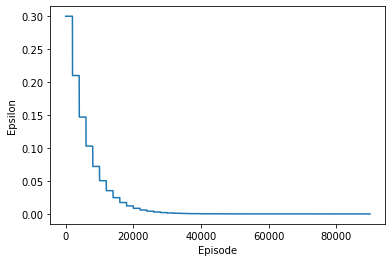

In [0]:
plt.plot([ EPSILON*((1-EPSILON)**(i//2000)) for i in range(90000)])
plt.xlabel('Episode')
plt.ylabel('Epsilon')

In [0]:
def run_epsilon_greedy_q_learning():
  episodes = 90000
  EPOCH = 2000
  num_combinations = len(ACTIONS)  # number of possible state spaces as well as action spaces
  Q = np.zeros((num_combinations, T , num_combinations)) # Initializing State Action Values
  rewards_q_learning = np.zeros(episodes)
  fin_states = []
  for i in range(0, episodes):
    eps = EPSILON*((1-EPSILON)**(i//EPOCH))
    rw, f = q_learning(Q, eps=eps, gamma=GAMMA)
    rewards_q_learning[i] += rw
    fin_states.append(f)
  return rewards_q_learning, Q, fin_states

In [0]:
rws, Q, f_sts = run_epsilon_greedy_q_learning()

In [0]:
START

[0.1, 0.2, 0.3, 0.4]

In [0]:
Q

array([[[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [2.48139001e-01, 1.99187056e+01, 2.42538992e-01, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 2.43674563e-01, ...,
         0.00000000e+00, 2.41937256e+01, 6.48469883e-01],
        ...,
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         8.10177436e-01, 0.00000000e+00, 3.04171934e-01],
        [8.96542106e-01, 2.05373317e+01, 8.41466266e-01, ...,
         2.20413356e-01, 5.77921079e-01, 4.31235202e-01],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

       [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [1.29710646e+01, 1.88097002e+01, 7.28869809e+00, ...,
         2.11609116e+02, 9.62463760e+00, 1.03138116e+01],
        [0.00000000e+00, 

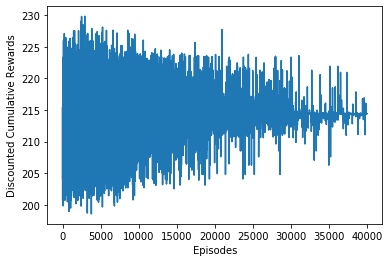

In [0]:
axs = plt.gca()
axs.plot(range(40000), rws[:40000])
axs.set_xlabel("Episodes")
axs.set_ylabel("Discounted Cumulative Rewards")
plt.show()

In [0]:
def print_optimal_policy(q_value):
    optimal_policy = []
    for i in range(0, len(ACTIONS)):
        best_action_list = []
        for j in range(0, T):
            bestAction = ACTIONS[np.argmax(q_value[i, j, :])]
            best_action_list.append(bestAction)  
        optimal_policy.append(best_action_list)     
    return np.array(optimal_policy)

In [0]:
optimal_policy = print_optimal_policy(Q)

In [0]:
sub_optimal_array=[]
for i in range(T-1):
  sub_optimal_array.append(ACTIONS[np.random.choice(len(ACTIONS))])

In [0]:
def sub_optimal_policy(gamma=GAMMA):
  sub_optimal_array=[]
  for i in range(T-1):
    sub_optimal_array.append(ACTIONS[np.random.choice(len(ACTIONS))])
  state = ACTIONS.index(START)
    #print(state)
  rewards = 0.0
  i = 0
  cum_rewards = []
  while i <= T-2:
    action = sub_optimal_array[i]
    next_state = ACTIONS.index(action)
    reward = reward_function(ACTIONS[state], action, var_cov, expected_asset_return)
    #print(reward)
    rewards += (gamma ** i) * reward
    cum_rewards.append(rewards)
    #print(Q[state, i, next_state])
    state = next_state
    i+= 1
  return cum_rewards

In [0]:
cumulative_reward_array= sub_optimal_policy(gamma=GAMMA)
#print(cumulative_reward_array)
#plt.plot(range(99), cumulative_reward_array)
#plt.ylim(bottom=181,top = 300)

In [0]:
#Plot Cumulative reward with time
#Make EPSILON = 0
#Start Exploition
#Remove Update of q value
#Store each reward
def exploitation_mode_optimal_policy(q_value, step_size=ALPHA, eps=0, gamma=GAMMA):
    state = ACTIONS.index(START)
    #print(state)
    rewards = 0.0
    rewards_array=[]
    i = 0
    while i <= T-2:
        action = choose_action(ACTIONS[state], i, q_value, eps)
        next_state = ACTIONS.index(action)
        reward = reward_function(ACTIONS[state], action, var_cov, expected_asset_return)
        #print(reward)
        rewards += (gamma ** i) * reward
        #print(Q[state, i, next_state])
        state = next_state
        i+= 1
        rewards_array.append(rewards)
    return rewards_array

In [0]:
cumulative_reward_array_optimal= exploitation_mode_optimal_policy(Q, step_size=ALPHA, eps=0, gamma=GAMMA)
#plt.plot(range(99), cumulative_reward_array_optimal)
#plt.ylim(bottom=40,top = 240)

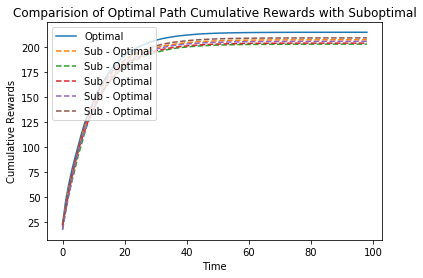

In [0]:
fig=plt.figure()
ax=fig.add_subplot(111)
ax.plot(range(T-1), cumulative_reward_array_optimal, label = "Optimal")
runs = 0
while(runs < 5):
  cumulative_rewards= sub_optimal_policy(gamma=GAMMA)
  ax.plot(range(T-1), cumulative_rewards, label = "Sub - Optimal", linestyle="--")
  runs += 1
plt.title("Comparision of Optimal Path Cumulative Rewards with Suboptimal")
plt.legend(loc=2)
plt.xlabel("Time")
plt.ylabel("Cumulative Rewards")
plt.show()

In [0]:
def single_cum_return(mean,risk,gamma):
  cum_reward_arr = []
  #cum_reward_arr.append(0)
  for t in range(T-1):
    cum_reward_arr.append((gamma**t)*(mean-0.5*risk**2))
  return cum_reward_arr

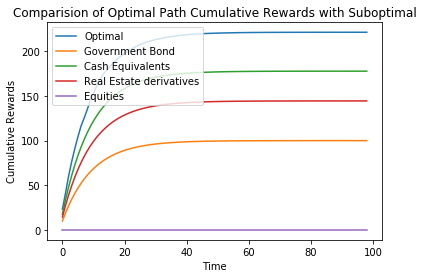

In [0]:
fig=plt.figure()
ax=fig.add_subplot(111)
ax.plot(range(T-1), cumulative_reward_array_optimal,label = "Optimal")
ax.plot(range(T-1), np.cumsum(single_cum_return(expected_asset_return[0],asset_risk[0],GAMMA)), label = 'Government Bond')
ax.plot(range(T-1), np.cumsum(single_cum_return(expected_asset_return[1],asset_risk[1],GAMMA)), label = 'Cash Equivalents')
ax.plot(range(T-1), np.cumsum(single_cum_return(expected_asset_return[2],asset_risk[2],GAMMA)), label = 'Real Estate derivatives')
ax.plot(range(T-1), np.cumsum(single_cum_return(expected_asset_return[3],asset_risk[3],GAMMA)), label = 'Equities')
plt.title("Comparision of Optimal Path Cumulative Rewards with Suboptimal")
plt.legend(loc=2)
plt.xlabel("Time")
plt.ylabel("Cumulative Rewards")
plt.show()

In [0]:
start_index = ACTIONS.index(START)
optimal_policy_indices = []
#optimal_policy_indices.append(start_index)

In [0]:
for i in range(T-1):
  next_state = ACTIONS.index(list(optimal_policy[start_index, i, :]))
  optimal_policy_indices.append(next_state)
  start_index = next_state

In [0]:
optimal_action_path = []
for ind in optimal_policy_indices:
  optimal_action_path.append(ACTIONS[ind])

In [0]:
optimal_action_path = np.array(optimal_action_path)

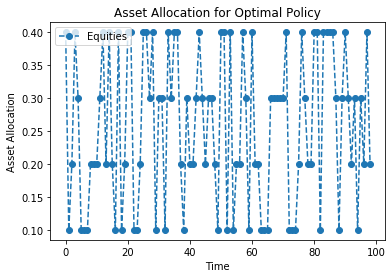

In [0]:
fig = plt.figure()
ax=fig.add_subplot(111)
#ax.plot(range(T-1), cumulative_reward_array_optimal)
#for ind, asset_type in enumerate(asset_types):
ax.plot(range(T-1), optimal_action_path[:, 3], label=asset_types[3], linestyle='--', marker='o')
plt.legend(loc=2)
plt.title("Asset Allocation for Optimal Policy")
plt.xlabel("Time")
plt.ylabel("Asset Allocation")
plt.show()

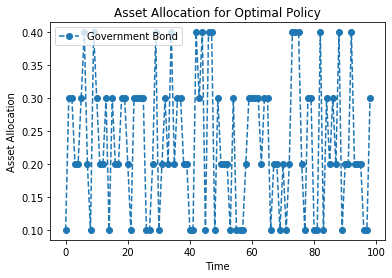

In [0]:
fig = plt.figure()
ax=fig.add_subplot(111)
#ax.plot(range(T-1), cumulative_reward_array_optimal)
#for ind, asset_type in enumerate(asset_types):
ax.plot(range(T-1), optimal_action_path[:, 0], label=asset_types[0], linestyle='--', marker='o')
plt.legend(loc=2)
plt.title("Asset Allocation for Optimal Policy")
plt.xlabel("Time")
plt.ylabel("Asset Allocation")
plt.show()

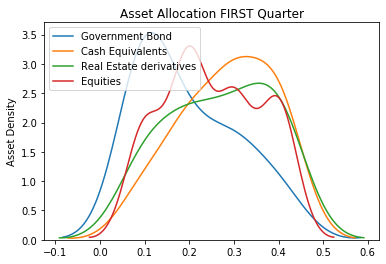

In [0]:
import seaborn as sns
fig = plt.figure()
sns.kdeplot(optimal_action_path[:25,0], label=asset_types[0])
sns.kdeplot(optimal_action_path[:25,1], label=asset_types[1])
sns.kdeplot(optimal_action_path[:25,2], label=asset_types[2])
sns.kdeplot(optimal_action_path[:25,3], label=asset_types[3])
plt.legend(loc=2)
plt.title("Asset Allocation FIRST Quarter")
plt.ylabel("Asset Density")
plt.show()

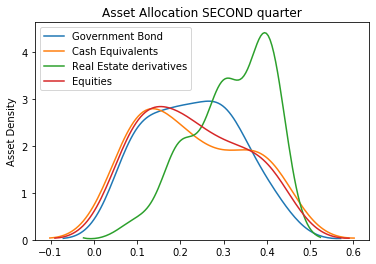

In [0]:
import seaborn as sns
fig = plt.figure()
sns.kdeplot(optimal_action_path[25:50,0], label=asset_types[0])
sns.kdeplot(optimal_action_path[25:50,1], label=asset_types[1])
sns.kdeplot(optimal_action_path[25:50,2], label=asset_types[2])
sns.kdeplot(optimal_action_path[25:50,3], label=asset_types[3])
plt.legend(loc=2)
plt.title("Asset Allocation SECOND quarter")
plt.ylabel("Asset Density")
plt.show()

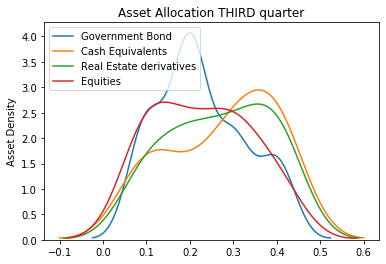

In [0]:
fig = plt.figure()
sns.kdeplot(optimal_action_path[50:75,0], label=asset_types[0])
sns.kdeplot(optimal_action_path[50:75,1], label=asset_types[1])
sns.kdeplot(optimal_action_path[50:75,2], label=asset_types[2])
sns.kdeplot(optimal_action_path[50:75,3], label=asset_types[3])
plt.legend(loc=2)
plt.title("Asset Allocation THIRD quarter")
plt.ylabel("Asset Density")
plt.show()

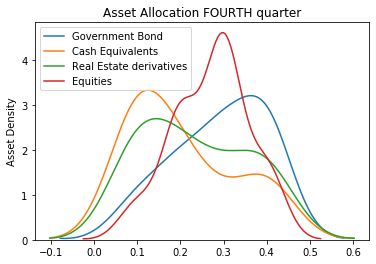

In [0]:
fig = plt.figure()
sns.kdeplot(optimal_action_path[75:100,0], label=asset_types[0])
sns.kdeplot(optimal_action_path[75:100,1], label=asset_types[1])
sns.kdeplot(optimal_action_path[75:100,2], label=asset_types[2])
sns.kdeplot(optimal_action_path[75:100,3], label=asset_types[3])
plt.legend(loc=2)
plt.title("Asset Allocation FOURTH quarter")
plt.ylabel("Asset Density")
plt.show()

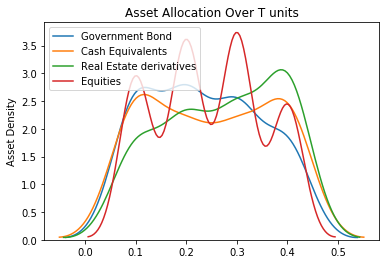

In [0]:
fig = plt.figure()
sns.kdeplot(optimal_action_path[:,0], label=asset_types[0])
sns.kdeplot(optimal_action_path[:,1], label=asset_types[1])
sns.kdeplot(optimal_action_path[:,2], label=asset_types[2])
sns.kdeplot(optimal_action_path[:,3], label=asset_types[3])
plt.legend(loc=2)
plt.title("Asset Allocation Over T units")
plt.ylabel("Asset Density")
plt.show()